In [79]:
# Rod (1D)

# Following this video: https://www.youtube.com/watch?v=CXOrkQs4WYo

import numpy as np
import matplotlib.pyplot as plt

alpha = 110
length = 50 # length of the rod, 50 mm
time = 1 # total time, 10 s
nodes = 20 # number of nodes - 1

dx = length / nodes # distance between nodes
dt = 0.2 * dx**2 / alpha # time step, must be less than dx^2 / (2 * alpha)

x_train_1d = np.linspace(0, length, nodes)
t_train_1d = np.linspace(0, time, int(time / dt))

u = np.zeros(nodes) + 20 # middle of the rod is 20 degrees
u[0] = 100 # left end of the rod is 100 degrees
u[-1] = 0 # right end of the rod is 0 degrees

heat_data_1d = np.zeros((int(time / dt), nodes))

for counter in range(heat_data_1d.shape[0]):
    w = u.copy()
    heat_data_1d[counter, :] = u.copy()

    for i in range(1, nodes - 1):
        u[i] = dt * alpha * (w[i - 1] - 2 * w[i] + w[i + 1]) / dx**2 + w[i]
    
    

    # print(f't: {counter * dt:.3f} s, Ave temp: {np.mean(u):.2f} C')

# heat_data_scaled = (heat_data_1d - np.min(heat_data_1d))
# heat_data_scaled = heat_data_scaled / np.max(heat_data_scaled)

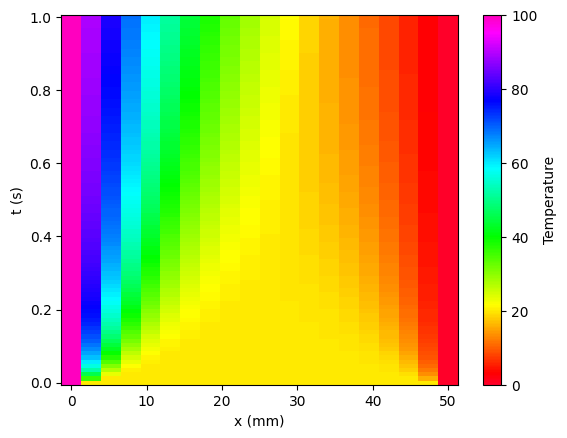

In [82]:
fig, axis = plt.subplots()
pcm = axis.pcolormesh(x_train_1d, t_train_1d, heat_data_1d, cmap='gist_rainbow', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature')
# axis.set_title(f't: {450*dt:.3f} s')
plt.xlabel('x (mm)')
plt.ylabel('t (s)')
plt.show()

In [83]:
import os
import sys

parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

In [84]:
from deep_learning import deep_network_core as core, utils
import torch
import torch.nn as nn
from torch.autograd import grad as autograd

In [99]:
# torch.manual_seed(1234)
# np.random.seed(1234)

Tr_1d, Xr_1d = np.meshgrid(t_train_1d, x_train_1d)

inpt_1d = np.column_stack((Tr_1d.T.ravel(), Xr_1d.T.ravel()))
oupt_1d = heat_data_1d.ravel()


In [108]:
inpt_1d.shape

(1760, 2)

In [114]:
class MSE_Loss(core.LOSS):
    def __init__(self):
        self.loss = nn.MSELoss()
        
    def __call__(self, target, result, model):
        return self.loss(target, result)

class Huber_Loss(core.LOSS):
    def __init__(self):
        self.loss = nn.HuberLoss()
        
    def __call__(self, target, result, model):
        return self.loss(target, result)

class PHYSICS_Loss(core.LOSS):
    # def __init__(self, bounds):
    #     self.bounds = bounds
    
    def __call__(self, target, result, model):
        x = torch.empty((100, 1)).uniform_(0, length).requires_grad_(True)
        t = torch.empty((100, 1)).uniform_(0, time).requires_grad_(True)
        inp = torch.cat((x, t), axis=1)
        zs = model(inp)
        pde = utils.dy_dt(zs, t) - utils.laplacian_1d(zs, x) # dz/dt - ddz/dxx
        return torch.mean(pde**2)

In [115]:
network_pinn_1d = core.PINN(2, 1, 128, 8, [(1, MSE_Loss()), (1, PHYSICS_Loss())])

In [117]:
print("Training PINN")
network_pinn_1d.fit(inpt_1d, oupt_1d, lr=1e-4, epochs=6000)

# Try a learning rate scheduler
# Try Huber loss (a feature in PyTorch)
# See if I can find someone else's PINN on the Heat Eqn

Training NN
Epoch 1/6000 loss: 3.1


Epoch 600/6000 loss: 1.6
Epoch 1200/6000 loss: 1.1
Epoch 1800/6000 loss: 0.87
Epoch 2400/6000 loss: 0.44
Epoch 3000/6000 loss: 0.43
Epoch 3600/6000 loss: 0.64
Epoch 4200/6000 loss: 0.43
Epoch 4800/6000 loss: 0.67
Epoch 5400/6000 loss: 0.25
Epoch 6000/6000 loss: 0.21


[3.0964601039886475,
 98.42631530761719,
 22.68660545349121,
 41.79350662231445,
 37.258514404296875,
 6.703645706176758,
 17.2148380279541,
 27.67070960998535,
 27.333261489868164,
 16.636058807373047,
 5.423656463623047,
 9.019254684448242,
 17.88804817199707,
 13.755627632141113,
 4.717585563659668,
 4.838803768157959,
 12.791038513183594,
 13.75512981414795,
 8.102502822875977,
 3.950465202331543,
 3.9931607246398926,
 8.975715637207031,
 8.784965515136719,
 5.637160778045654,
 3.9532370567321777,
 5.344828128814697,
 7.806757926940918,
 4.823204040527344,
 3.846212387084961,
 3.395634412765503,
 5.4102983474731445,
 4.523411750793457,
 3.310957431793213,
 4.210592746734619,
 3.9995734691619873,
 5.424287796020508,
 3.3463499546051025,
 3.280050277709961,
 3.363847017288208,
 3.7760472297668457,
 3.1086983680725098,
 2.6805624961853027,
 3.0451362133026123,
 3.4088268280029297,
 3.317772388458252,
 3.0828471183776855,
 4.966994285583496,
 3.1759915351867676,
 3.499816417694092,
 3.

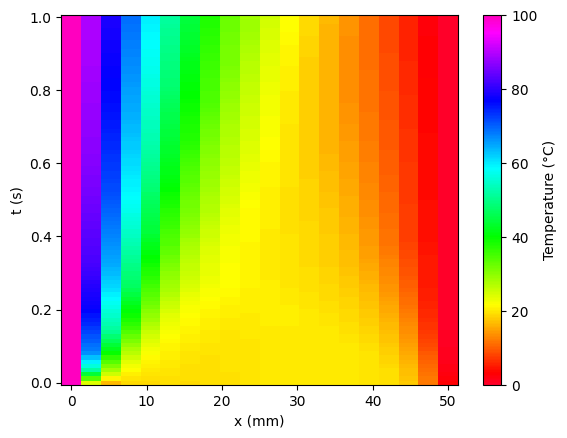

In [118]:
predicted = network_pinn_1d.predict(inpt_1d).reshape(heat_data_1d.shape)

fig, axis = plt.subplots()
pcm = axis.pcolormesh(x_train_1d, t_train_1d, predicted, cmap='gist_rainbow', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature (°C)')
# axis.set_title(f't: {450*dt:.3f} s')
plt.xlabel('x (mm)')
plt.ylabel('t (s)')
plt.show()

In [95]:
network_dgm = core.DGM(2, 1, 128, 4, [(1, MSE_Loss()), (1, PHYSICS_Loss())])
print("Training DGM")
network_dgm.fit(inpt_1d, oupt_1d, lr=1e-2, epochs=200)

Training DGM


Epoch 1/200 loss: 1.6e+03
Epoch 20/200 loss: 8.7e+02
Epoch 40/200 loss: 7.9e+02
Epoch 60/200 loss: 6.9e+02
Epoch 80/200 loss: 6.8e+02
Epoch 100/200 loss: 6.8e+02
Epoch 120/200 loss: 6.8e+02
Epoch 140/200 loss: 6.8e+02
Epoch 160/200 loss: 6.8e+02
Epoch 180/200 loss: 6.8e+02
Epoch 200/200 loss: 6.8e+02


[1592.8905029296875,
 1278.064697265625,
 1051.486328125,
 913.3497924804688,
 858.962890625,
 872.9617309570312,
 924.2321166992188,
 972.7529907226562,
 994.5880737304688,
 986.8743286132812,
 958.5134887695312,
 921.9609375,
 887.906005859375,
 862.9627685546875,
 849.9675903320312,
 847.7084350585938,
 852.8181762695312,
 861.1891479492188,
 869.0609741210938,
 873.7396850585938,
 873.581298828125,
 868.7048950195312,
 860.643798828125,
 851.2183837890625,
 842.2091064453125,
 835.4425659179688,
 831.7578125,
 831.1820678710938,
 832.512939453125,
 834.2653198242188,
 834.6725463867188,
 832.78369140625,
 828.9176025390625,
 823.0177612304688,
 816.5294189453125,
 810.1929321289062,
 803.504150390625,
 797.4153442382812,
 791.9444580078125,
 786.86474609375,
 781.10302734375,
 775.0204467773438,
 769.645751953125,
 763.8659057617188,
 757.2234497070312,
 749.2769775390625,
 742.0115356445312,
 733.998046875,
 725.8494262695312,
 719.413330078125,
 713.9358520507812,
 708.2923583984

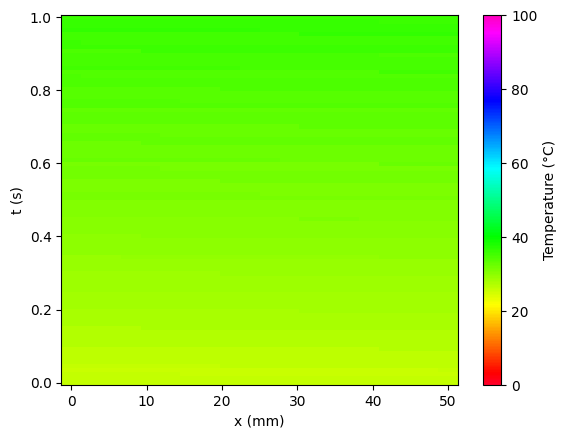

In [94]:
predicted = network_dgm.predict(inpt_1d).reshape(heat_data_1d.shape)

fig, axis = plt.subplots()
pcm = axis.pcolormesh(x_train_1d, t_train_1d, predicted, cmap='gist_rainbow', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature (°C)')
# axis.set_title(f't: {450*dt:.3f} s')
plt.xlabel('x (mm)')
plt.ylabel('t (s)')
plt.show()